In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 3.8MB 37.4MB/s 
     |████████████████████████████████| 450kB 55.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# load data  
# split train and test
from sklearn.model_selection import train_test_split
spectra_all = np.load('/content/drive/My Drive/2nd_data/LAMOST_spec_SNR100_ab.npy')
label_all = np.load('/content/drive/My Drive/2nd_data/LAMOST_label_SNR100_ab.npy')
spectra_train, spectra_test, label_train, label_test = train_test_split(spectra_all,
                                                    label_all,
                                                    test_size = 0.2,
                                                    random_state = 27)
x_train = np.expand_dims(spectra_train,axis=2)
x_test = np.expand_dims(spectra_test,axis=2)
y_train = tf.one_hot(label_train, depth = 7, axis = 1 ,dtype=tf.int8)
y_test = tf.one_hot(label_test, depth = 7, axis = 1 ,dtype=tf.int8)

In [0]:
np.random.seed(27)
tf.random.set_seed(27)

In [0]:
tf.compat.v1.reset_default_graph()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters=16,kernel_size=16,padding="valid",activation="relu",input_shape =(4096,1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model.add(tf.keras.layers.Conv1D(filters=16,kernel_size=8,padding="valid",activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=32,kernel_size=4,padding="valid",activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(7,activation="softmax")) #2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4081, 16)          272       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1020, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1013, 16)          2064      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 506, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 503, 32)           2080      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 251, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 251, 32)           0

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
lamost_hs = model.fit(x_train, y_train,
          batch_size=50,
          epochs=5,
          validation_data=(x_test, y_test))
#test_accuracy = model.evaluate(x_test, y_test, verbose=0)
#print('\n', 'Test_Accuracy = ', test_accuracy[1])
#model.save('CNN_LAMOST.h5')


Train on 79984 samples, validate on 19996 samples
Epoch 1/5
79984/79984 [==============================] - 17s 209us/sample - loss: 27.7800 - accuracy: 0.6329 - val_loss: 1.2711 - val_accuracy: 0.4344
Epoch 2/5
79984/79984 [==============================] - 16s 196us/sample - loss: 0.7588 - accuracy: 0.7132 - val_loss: 0.4707 - val_accuracy: 0.8564
Epoch 3/5
79984/79984 [==============================] - 16s 197us/sample - loss: 0.4638 - accuracy: 0.8261 - val_loss: 0.2896 - val_accuracy: 0.8758
Epoch 4/5
79984/79984 [==============================] - 16s 199us/sample - loss: 0.4726 - accuracy: 0.8353 - val_loss: 0.3336 - val_accuracy: 0.8733
Epoch 5/5
79984/79984 [==============================] - 16s 198us/sample - loss: 0.3955 - accuracy: 0.8557 - val_loss: 0.3092 - val_accuracy: 0.8725


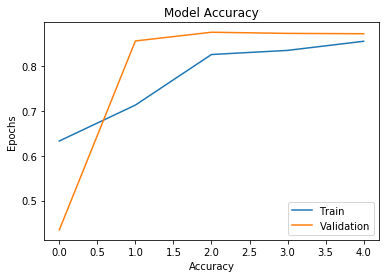

In [0]:
plt.plot(lamost_hs.history['accuracy'])
plt.plot(lamost_hs.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [0]:
prediction = model.predict(x_test)
predicted_label = np.zeros((len(label_test)))
for i in range(len(prediction)):
    predicted_label[i] = np.argmax(prediction[i])
cm = tf.math.confusion_matrix(label_test,predicted_label)

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.xlim(xmax = len(target_names)-0.5)
    plt.ylim(6.5,-0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('cm.pdf')
    plt.show()

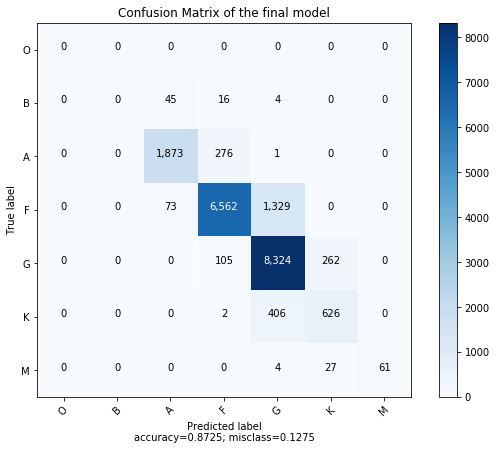

In [0]:
plot_confusion_matrix(np.array(cm), ['O','B','A','F','G','K','M'], title = "Confusion Matrix of the final model")